##### Title: Monitoring how RTT varies based on the geolocation of the target
##### Author: Lotito Davide Pio
##### Date: 
<img src="./images/logoUnipvST.jpg" width="75" height="75">

## Some useful imports

In [4]:
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
from glob import glob
import getCoordinate
import haversine as hs

## Read all files and create a unique dataframe 

In [5]:
dirPath = '../results/'
allFiles = glob(os.path.join(dirPath, "*.txt"))
indDf = (pd.read_json(f) for f in allFiles)
df = pd.concat(indDf, ignore_index=True)
df

,destination,date,time,packetLost,excutionTime,minRTT,avgRTT,maxRTT,devRTT
0,142.250.184.110,2022-04-15,23:16:38,0%,9013ms,13.616,18.534,24.803,3.466
1,31.13.86.36,2022-04-15,23:16:38,0%,9013ms,12.910,15.826,19.084,2.264
2,140.82.121.3,2022-04-15,23:16:38,0%,9013ms,21.742,33.185,107.534,25.046
3,13.107.42.14,2022-04-15,23:16:38,0%,9014ms,13.646,17.258,25.216,3.248
4,142.250.184.46,2022-04-15,24:17:38,0%,9015ms,12.946,14.604,18.829,1.667
5,31.13.86.36,2022-04-15,24:17:38,0%,9013ms,11.908,14.601,20.505,2.704
6,140.82.121.4,2022-04-15,24:17:38,0%,9012ms,20.962,23.306,27.478,1.627
7,13.107.42.14,2022-04-15,24:17:38,0%,9014ms,12.451,15.610,20.961,2.797
8,142.250.184.110,2022-04-15,24:09:08,0%,9014ms,12.782,15.049,21.349,2.626
9,31.13.86.36,2022-04-15,24:09:08,0%,9012ms,12.156,13.361,16.170,1.232


## Sort in ascending order by RTT

In [6]:
#df.sort_values('avgRTT')

## Coordinate degli IP

In [7]:
IP_list = df['destination'].tolist()

## Plottare posizione sulla mappa degli IP

POINT (-97.822 37.751)
POINT (-6.2439 53.3472)
POINT (-97.822 37.751)
POINT (-97.822 37.751)
POINT (-97.822 37.751)
POINT (-6.2439 53.3472)
POINT (-97.822 37.751)
POINT (-97.822 37.751)
POINT (-97.822 37.751)
POINT (-6.2439 53.3472)
POINT (-97.822 37.751)
POINT (-97.822 37.751)
POINT (-97.822 37.751)
POINT (-6.2439 53.3472)
POINT (-97.822 37.751)
POINT (-97.822 37.751)


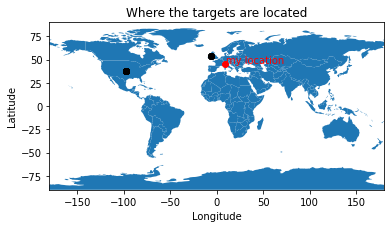

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

points = gpd.GeoDataFrame()
# punto = Point(longitudine, latitudine)
my_points = []
i = 0
for ip in IP_list:
    point = Point(getCoordinate.coordinates(ip))
    print(point)
    os.system("sleep 1")# wait because of the free-API
    my_points.append(point)
    i+=1

points["geometry"] = gpd.GeoSeries(my_points)
ax = world.plot()
points.plot(color="k", ax=ax)

my_point = Point(9, 45)
my_location = gpd.GeoSeries(my_point)
my_location.plot(color="r", ax=ax)

plt.text(my_point.x+1,my_point.y+1,"my location", color='red')
plt.rcParams["figure.figsize"] = (25, 10)
plt.title("Where the targets are located")
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Calcolare distanza tra la mia posizione e IP target

In [15]:
distances = []
for p in my_points:
    d = hs.haversine((my_point.y, my_point.x),(p.y, p.x)) #lat, long
    distances.append(d)

In [16]:
df = df.assign(distance=distances)
df

,destination,date,time,packetLost,excutionTime,minRTT,avgRTT,maxRTT,devRTT,distance
0,142.250.184.110,2022-04-15,23:16:38,0%,9013ms,13.616,18.534,24.803,3.466,8258.414178
1,31.13.86.36,2022-04-15,23:16:38,0%,9013ms,12.910,15.826,19.084,2.264,1440.304306
2,140.82.121.3,2022-04-15,23:16:38,0%,9013ms,21.742,33.185,107.534,25.046,8258.414178
3,13.107.42.14,2022-04-15,23:16:38,0%,9014ms,13.646,17.258,25.216,3.248,8258.414178
4,142.250.184.46,2022-04-15,24:17:38,0%,9015ms,12.946,14.604,18.829,1.667,8258.414178
5,31.13.86.36,2022-04-15,24:17:38,0%,9013ms,11.908,14.601,20.505,2.704,1440.304306
6,140.82.121.4,2022-04-15,24:17:38,0%,9012ms,20.962,23.306,27.478,1.627,8258.414178
7,13.107.42.14,2022-04-15,24:17:38,0%,9014ms,12.451,15.610,20.961,2.797,8258.414178
8,142.250.184.110,2022-04-15,24:09:08,0%,9014ms,12.782,15.049,21.349,2.626,8258.414178
9,31.13.86.36,2022-04-15,24:09:08,0%,9012ms,12.156,13.361,16.170,1.232,1440.304306


## Ordinare per distanza minore

In [11]:
df.sort_values('distance')

,destination,date,time,packetLost,excutionTime,minRTT,avgRTT,maxRTT,devRTT,distance
1,31.13.86.36,2022-04-15,23:16:38,0%,9013ms,12.910,15.826,19.084,2.264,1440.304306
5,31.13.86.36,2022-04-15,24:17:38,0%,9013ms,11.908,14.601,20.505,2.704,1440.304306
9,31.13.86.36,2022-04-15,24:09:08,0%,9012ms,12.156,13.361,16.170,1.232,1440.304306
13,31.13.86.36,2022-04-15,23:28:33,0%,9012ms,13.111,29.090,111.038,27.734,1440.304306
0,142.250.184.110,2022-04-15,23:16:38,0%,9013ms,13.616,18.534,24.803,3.466,8258.414178
2,140.82.121.3,2022-04-15,23:16:38,0%,9013ms,21.742,33.185,107.534,25.046,8258.414178
3,13.107.42.14,2022-04-15,23:16:38,0%,9014ms,13.646,17.258,25.216,3.248,8258.414178
4,142.250.184.46,2022-04-15,24:17:38,0%,9015ms,12.946,14.604,18.829,1.667,8258.414178
6,140.82.121.4,2022-04-15,24:17:38,0%,9012ms,20.962,23.306,27.478,1.627,8258.414178
7,13.107.42.14,2022-04-15,24:17:38,0%,9014ms,12.451,15.610,20.961,2.797,8258.414178


## Grafici

A parità di destinazione IP si calcola la media, della media, dell' RTT. Poi se ne fa il grafico

Text(0, 0.5, 'rtt time [ms]')

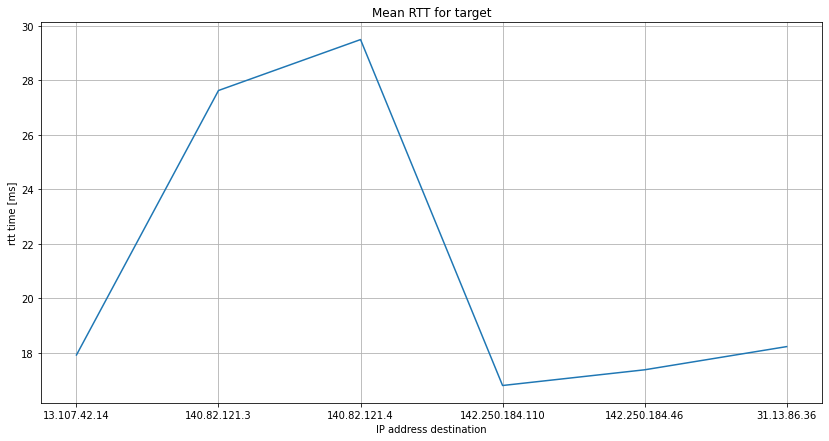

In [17]:
df.groupby("destination").avgRTT.mean().plot()
plt.grid()
plt.rcParams["figure.figsize"] = (14, 7)
plt.title("Mean RTT for target")
plt.xlabel("IP address destination")
plt.ylabel("rtt time [ms]")

Mostrare come con il crescere della distanza, cresca anche l'RTT (o almeno così dovrebbe accadere)

Text(0, 0.5, 'rtt time [ms]')

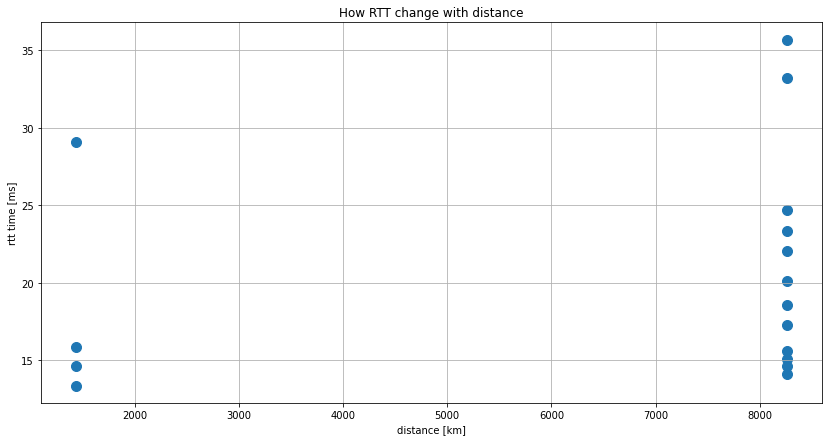

In [14]:
#df.sort_values("distance").groupby("distance").avgRTT.plot()
df.plot.scatter(x = 'distance', y = 'avgRTT', s = 100);
plt.grid()
plt.rcParams["figure.figsize"] = (14, 7)
plt.title("How RTT change with distance")
plt.xlabel("distance [km]")
plt.ylabel("rtt time [ms]")